In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 32  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])
unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
funlensedTT = lambda L:np.exp(funlensedTT_log(L))


L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK_log = interp1d(L, np.log(rawKK), kind='linear', bounds_error=False, fill_value=0.)
ffKK = lambda L:np.exp(fKK_log(L))


L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
flensedTT = lambda L:np.exp(flensedTT_log(L))


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT_log = interp1d(L, np.log(cTgradT), kind='linear', bounds_error=False, fill_value=0.)
fTgradT = lambda L:np.exp(fTgradT_log(L))


../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [6]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
# cmb.fCtotal = interp1d(L, F, kind='cubic', bounds_error=False, fill_value=0.)
cmb.fCtotal = ftot # no longer reinterpolating since it seems like it leads to errors?

In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [8]:
baseMap.sizeX

0.3490658503988659

In [9]:
baseMap.dX

0.00043633231299858234

In [10]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

In [11]:
L, ClExpected= baseMap.binTheoryPowerSpectrum(ftot, nBins=nBins)

In [12]:
def gen_clFourier(fcur):
    f = lambda l: np.sqrt(fcur(l))
    clFourier = np.array(list(map(f, baseMap.l.flatten())))
    clFourier = np.nan_to_num(clFourier)
    clFourier = clFourier.reshape(np.shape(baseMap.l))
    return clFourier
    
print('precomputing Cls')
clFourier_ftot = gen_clFourier(ftot)

precomputing Cls


In [13]:
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

def process_data(i):
    np.random.seed(i)
    totalCmbFourier = baseMap.genGRF(ftot, clFourier=clFourier_ftot)
    totalCmb = baseMap.inverseFourier(totalCmbFourier)

#     cmb0Fourier = baseMap.genGRF(funlensedTT, test=False)
#     cmb0 = baseMap.inverseFourier(cmb0Fourier)
    


#     kCmbFourier = baseMap.genGRF(fKK, test=False)

#     lensedCmb = baseMap.doLensing(unlensed=cmb0, kappaFourier=kCmbFourier)
#     lensedCmbFourier = baseMap.fourier(lensedCmb)
    
#     return lensedCmbFourier

#     fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
#     lensedCmbFourier = lensedCmbFourier + fgFourier
# 
#     noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
#     totalCmbFourier = lensedCmbFourier + noiseFourier

    return totalCmbFourier

with Pool() as p:
    res = list(tqdm(p.imap(process_data, range(256)), total=256))
c_data_new = np.array(res)

100%|██████████| 256/256 [00:01<00:00, 191.25it/s]


In [14]:
ck = 'GRF_new'

ps_data = {}


for data_idx in trange(256):
    curr_data = c_data_new[data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=curr_data, nBins=nBins)
    c_ps_data[ck][1] 
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 256/256 [00:04<00:00, 62.61it/s]


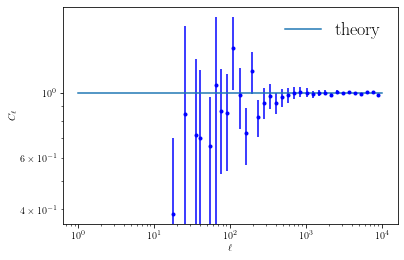

(array([1.10134950e+00, 1.32459194e+00, 1.59308540e+00, 1.91600222e+00,
        2.30437396e+00, 2.77146825e+00, 3.33324210e+00, 4.00888694e+00,
        4.82148431e+00, 5.79879436e+00, 6.97420418e+00, 8.38786839e+00,
        1.00880809e+01, 1.21329248e+01, 1.45922566e+01, 1.80000000e+01,
        2.11074786e+01, 2.54558441e+01, 3.05316487e+01, 3.60000000e+01,
        4.02492236e+01, 5.46119298e+01, 6.48999230e+01, 7.59686507e+01,
        9.23240847e+01, 1.11392712e+02, 1.35796705e+02, 1.61112716e+02,
        1.93604685e+02, 2.33437499e+02, 2.78217850e+02, 3.36081721e+02,
        4.06007460e+02, 4.87720155e+02, 5.87025726e+02, 7.05868439e+02,
        8.48636506e+02, 1.02092252e+03, 1.22775430e+03, 1.47687985e+03,
        1.77622062e+03, 2.13575670e+03, 2.56875901e+03, 3.08927265e+03,
        3.71521993e+03, 4.46882622e+03, 5.37502335e+03, 6.46445903e+03,
        7.62329283e+03, 9.02701246e+03]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [15]:
data = np.zeros_like(baseMap.data)
data = np.random.normal(loc=0., scale=1./np.sqrt(baseMap.dX*baseMap.dY), size=len(baseMap.x.flatten())) 
data = data.reshape(np.shape(baseMap.x))

# Fourier transform
dataFourier = baseMap.fourier(data)
# check that the power spectrum is Cl = 1
baseMap.powerSpectrum(dataFourier, theory=[lambda l:1.], plot=True)


In [16]:
# L, ClExpected= baseMap.binTheoryPowerSpectrum(flensedTT, nBins=nBins)

256 (256, 3, 31)


Text(0.5, 0, '$L$')

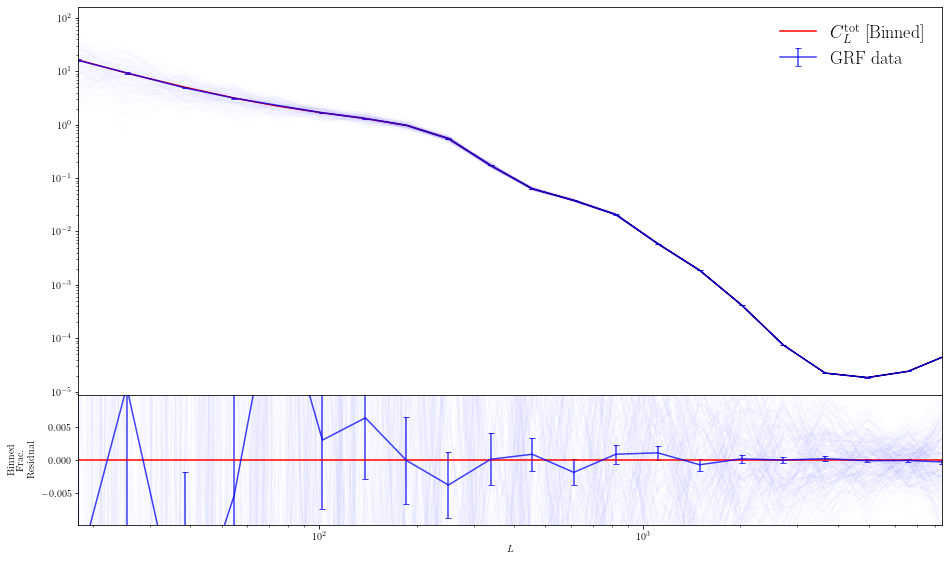

In [17]:
fig = plt.figure(figsize=(16,9))
axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]#,  fig.add_axes((0.2,-0.2,.75,.2))]
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20



    
lCen, Cl, sCl = combine_Cl(ps_data['GRF_new'])

Ipos = np.where(Cl>0)
axs[0].errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')\


assert((lCen[Ipos] == L[Ipos]).all())

axs[1].errorbar(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], yerr=sCl[Ipos]/ClExpected[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')


theoryIpos = np.where(ClExpected > 0)
axs[0].plot(L[theoryIpos], ClExpected[theoryIpos], 'red', label=r'$C_L^{\rm tot}$ [Binned]')    




unbinnedCl = np.array(list(map(ftot, L)))
# axs[0].plot(L[theoryIpos], unbinnedCl[theoryIpos], 'green', label=r'$C_L^{\rm tot}$ [Unbinned]')    

for lCen, Cl, sCl in ps_data['GRF_new']:
    Ipos = np.where(Cl>0)
    axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=0.005, color='blue')
    assert((lCen[Ipos] == L[Ipos]).all())
    axs[1].plot(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], alpha=0.01, color='blue')
#     axs[2].plot(lCen[Ipos], (Cl[Ipos] - unbinnedCl[Ipos])/unbinnedCl[Ipos], alpha=0.01, color='blue')

# axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=1, color='blue', label='GRFs')

axs[0].legend(frameon=False)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
axs[1].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
# axs[2].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])

axs[1].set_xscale('log')
# axs[1].set_yscale('log')

# axs[1].fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')

axs[1].axhline(0, c='red')


axs[1].set_ylim(-.98e-2, .98e-2)




# axs[2].set_xscale('log')
# axs[2].axhline(0, c='green')
# axs[2].set_ylim(-.98e-1, .98e-1)

axs[1].set_ylabel('Binned \nFrac. \nResidual')
# axs[2].set_ylabel('Un-binned \nFrac. \nResidual')
axs[1].set_xlabel(r'$L$')


In [18]:
### # In[12]:
ps_data = {}


print("Map properties")

# number of pixels for the flat map
nX = 1200
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins


for file_idx in trange(2, 51):
    try:
        fname = IN_DATA_FNAMES[file_idx-1]
        f = open(fname, 'rb') 
        c_in_data = pickle.load(f) 
        f.close()
    except:
        continue
    try:
        ck = 'lensed'
        for curr_data in c_in_data['totalF_1']:
            c_ps_data = {}
            c_ps_data[ck] = [0,0,0]
            c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=curr_data, nBins=nBins)
            if(ck not in ps_data.keys()):
                ps_data[ck] = np.array([c_ps_data[ck]])
            else:
                ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))    
    except:
        print(file_idx, ck)
    try:
        ck = 'GRF'
        for curr_data in c_in_data['totalF_0']:
            c_ps_data = {}
            c_ps_data[ck] = [0,0,0]
            c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=curr_data, nBins=nBins)
            if(ck not in ps_data.keys()):
                ps_data[ck] = np.array([c_ps_data[ck]])
            else:
                ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))    
    except:
        print(file_idx, ck)
    try:
        ck = 'TTrand'
        for curr_data in c_in_data['totalF_randomized_0']:
            c_ps_data = {}
            c_ps_data[ck] = [0,0,0]
            c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=curr_data, nBins=nBins)
            if(ck not in ps_data.keys()):
                ps_data[ck] = np.array([c_ps_data[ck]])
            else:
                ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  
    except:
        print(file_idx, ck)




Map properties


100%|██████████| 49/49 [03:12<00:00,  3.93s/it]


In [19]:
L, ClExpected= baseMap.binTheoryPowerSpectrum(ftot, nBins=nBins)

490 (490, 3, 50)


Text(0.5, 0, '$L$')

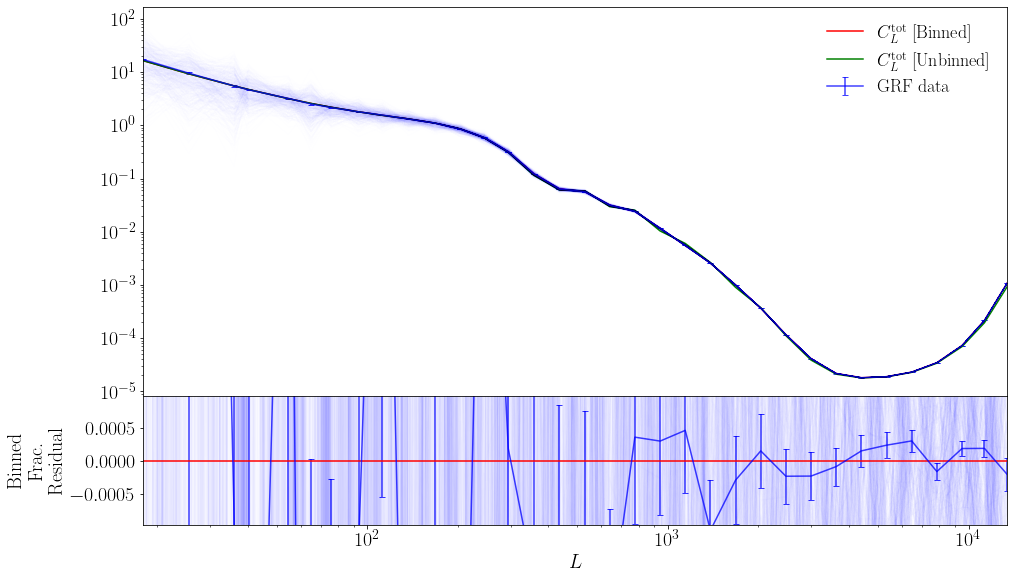

In [20]:
fig = plt.figure(figsize=(16,9))
axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]#,  fig.add_axes((0.2,-0.2,.75,.2))]
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20



    
lCen, Cl, sCl = combine_Cl(ps_data['GRF'])
Ipos = np.where(Cl>0)
axs[0].errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')

assert((lCen[Ipos] == L[Ipos]).all())

axs[1].errorbar(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], yerr=sCl[Ipos]/ClExpected[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')


theoryIpos = np.where(ClExpected > 0)
axs[0].plot(L[theoryIpos], ClExpected[theoryIpos], 'red', label=r'$C_L^{\rm tot}$ [Binned]')    


unbinnedCl = np.array(list(map(ftot, L)))
axs[0].plot(L[theoryIpos], unbinnedCl[theoryIpos], 'green', label=r'$C_L^{\rm tot}$ [Unbinned]')    

for lCen, Cl, sCl in ps_data['GRF']:
    Ipos = np.where(Cl>0)
    axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=0.005, color='blue')
    assert((lCen[Ipos] == L[Ipos]).all())
    axs[1].plot(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], alpha=0.01, color='blue')
#     axs[2].plot(lCen[Ipos], (Cl[Ipos] - unbinnedCl[Ipos])/unbinnedCl[Ipos], alpha=0.01, color='blue')

# axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=1, color='blue', label='GRFs')

axs[0].legend(frameon=False)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
axs[1].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
# axs[2].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])

axs[1].set_xscale('log')
# axs[1].set_yscale('log')

# axs[1].fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')

axs[1].axhline(0, c='red')


axs[1].set_ylim(-.98e-3, .98e-3)




# axs[2].set_xscale('log')
# axs[2].axhline(0, c='green')
# axs[2].set_ylim(-.98e-1, .98e-1)

axs[1].set_ylabel('Binned \nFrac. \nResidual')
# axs[2].set_ylabel('Un-binned \nFrac. \nResidual')
axs[1].set_xlabel(r'$L$')


490 (490, 3, 50)


Text(0.5, 0, '$L$')

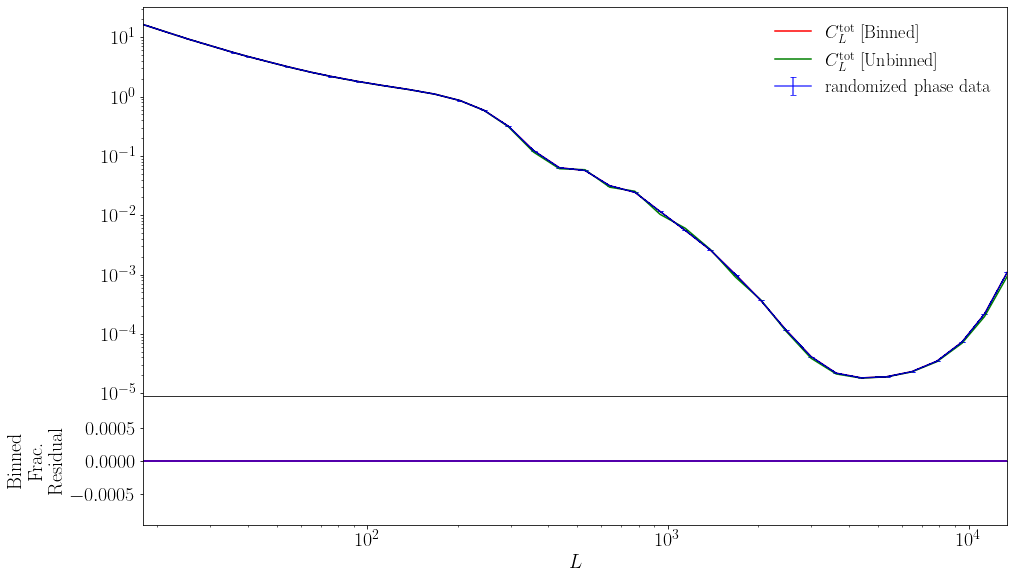

In [21]:
fig = plt.figure(figsize=(16,9))
axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]#,  fig.add_axes((0.2,-0.2,.75,.2))]
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20



    
lCen, Cl, sCl = combine_Cl(ps_data['TTrand'])
Ipos = np.where(Cl>0)
axs[0].errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='randomized phase data', c='blue')

assert((lCen[Ipos] == L[Ipos]).all())

axs[1].errorbar(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], yerr=sCl[Ipos]/ClExpected[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='randomized phase data', c='blue')


theoryIpos = np.where(ClExpected > 0)
axs[0].plot(L[theoryIpos], ClExpected[theoryIpos], 'red', label=r'$C_L^{\rm tot}$ [Binned]')    


unbinnedCl = np.array(list(map(ftot, L)))
axs[0].plot(L[theoryIpos], unbinnedCl[theoryIpos], 'green', label=r'$C_L^{\rm tot}$ [Unbinned]')    

for lCen, Cl, sCl in ps_data['TTrand']:
    Ipos = np.where(Cl>0)
    axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=0.005, color='blue')
    assert((lCen[Ipos] == L[Ipos]).all())
    axs[1].plot(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], alpha=0.01, color='blue')
#     axs[2].plot(lCen[Ipos], (Cl[Ipos] - unbinnedCl[Ipos])/unbinnedCl[Ipos], alpha=0.01, color='blue')

# axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=1, color='blue', label='GRFs')

axs[0].legend(frameon=False)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
axs[1].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
# axs[2].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])

axs[1].set_xscale('log')
# axs[1].set_yscale('log')

# axs[1].fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')

axs[1].axhline(0, c='red')


axs[1].set_ylim(-.98e-3, .98e-3)




# axs[2].set_xscale('log')
# axs[2].axhline(0, c='green')
# axs[2].set_ylim(-.98e-1, .98e-1)

axs[1].set_ylabel('Binned \nFrac. \nResidual')
# axs[2].set_ylabel('Un-binned \nFrac. \nResidual')
axs[1].set_xlabel(r'$L$')


490 (490, 3, 50)


Text(0.5, 0, '$L$')

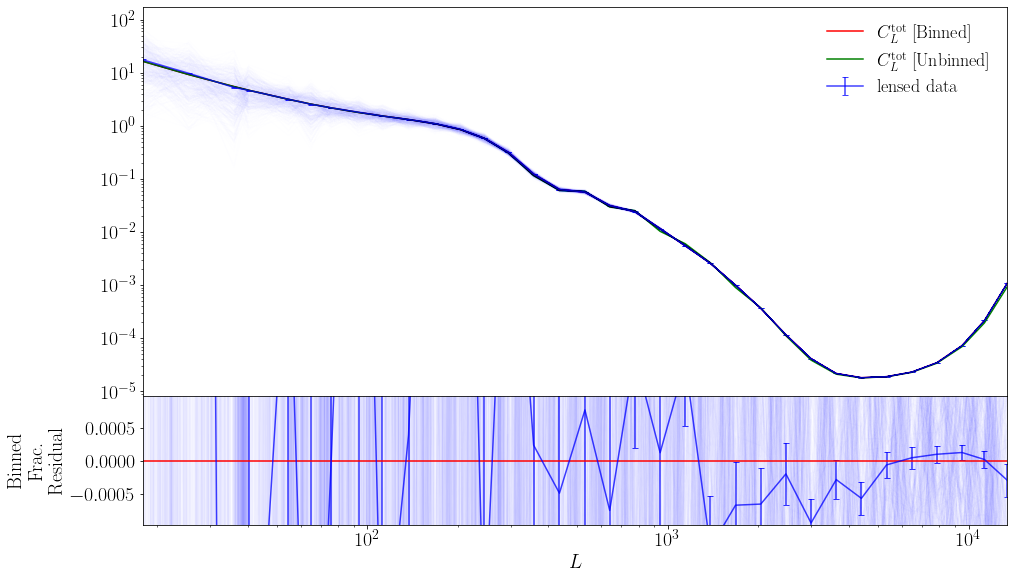

In [22]:
fig = plt.figure(figsize=(16,9))
axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]#,  fig.add_axes((0.2,-0.2,.75,.2))]
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20



    
lCen, Cl, sCl = combine_Cl(ps_data['lensed'])
Ipos = np.where(Cl>0)
axs[0].errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='lensed data', c='blue')

assert((lCen[Ipos] == L[Ipos]).all())

axs[1].errorbar(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], yerr=sCl[Ipos]/ClExpected[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='lensed data', c='blue')


theoryIpos = np.where(ClExpected > 0)
axs[0].plot(L[theoryIpos], ClExpected[theoryIpos], 'red', label=r'$C_L^{\rm tot}$ [Binned]')    


unbinnedCl = np.array(list(map(ftot, L)))
axs[0].plot(L[theoryIpos], unbinnedCl[theoryIpos], 'green', label=r'$C_L^{\rm tot}$ [Unbinned]')    

for lCen, Cl, sCl in ps_data['lensed']:
    Ipos = np.where(Cl>0)
    axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=0.005, color='blue')
    assert((lCen[Ipos] == L[Ipos]).all())
    axs[1].plot(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], alpha=0.01, color='blue')
#     axs[2].plot(lCen[Ipos], (Cl[Ipos] - unbinnedCl[Ipos])/unbinnedCl[Ipos], alpha=0.01, color='blue')

# axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=1, color='blue', label='GRFs')

axs[0].legend(frameon=False)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
axs[1].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
# axs[2].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])

axs[1].set_xscale('log')
# axs[1].set_yscale('log')

# axs[1].fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')

axs[1].axhline(0, c='red')


axs[1].set_ylim(-.98e-3, .98e-3)




# axs[2].set_xscale('log')
# axs[2].axhline(0, c='green')
# axs[2].set_ylim(-.98e-1, .98e-1)

axs[1].set_ylabel('Binned \nFrac. \nResidual')
# axs[2].set_ylabel('Un-binned \nFrac. \nResidual')
axs[1].set_xlabel(r'$L$')
